# Active Learning (POC)

Active learning is used when the cost of getting pre-labelled data is high. Active learning is a special case of semi-supervised machine learning in which a learning algorithm is able to interactively query the user to obtain the desired outputs at new data points.

- The objective is to find which sample needs to be 'resolved' (or labelled) by the supervisor to train the model.
- The algorithm then takes this sample to train itself again and repeats this process infinitely.

For better intuition, the algorithm tries to look at which samples fall very close to the decision boundry. These samples are the ones that will cause "uncertainity" in the algorithm. These are sent to the user for labeling. Once labeled, these are used to train the algorithm and move repeat.

There are different strategiesd used to decide what to ask the supervisor for labels. Two most popular ones are - 
- Uncertainity (how close is the sample to the decision boundry/hyperplane)
- Entropy reduction in the system
- Committee votes (used in ensemble learners, where multiple models decide what sample to ask for labeling)

<img src='http://inspirehep.net/record/1667231/files/plots_active_learning_09.png' width="500" height="600">

## Importing dependencies

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import missingno as msno
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import json

%matplotlib inline

## Loading data 
Housing data

https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data

In [13]:
df1 = pd.read_json("train.json")

In [14]:
df = df1[:800]

In [15]:
df.shape

(800, 15)

In [16]:
var = ['bathrooms','bedrooms','latitude','longitude','price']

In [17]:
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high


## Handling missing data

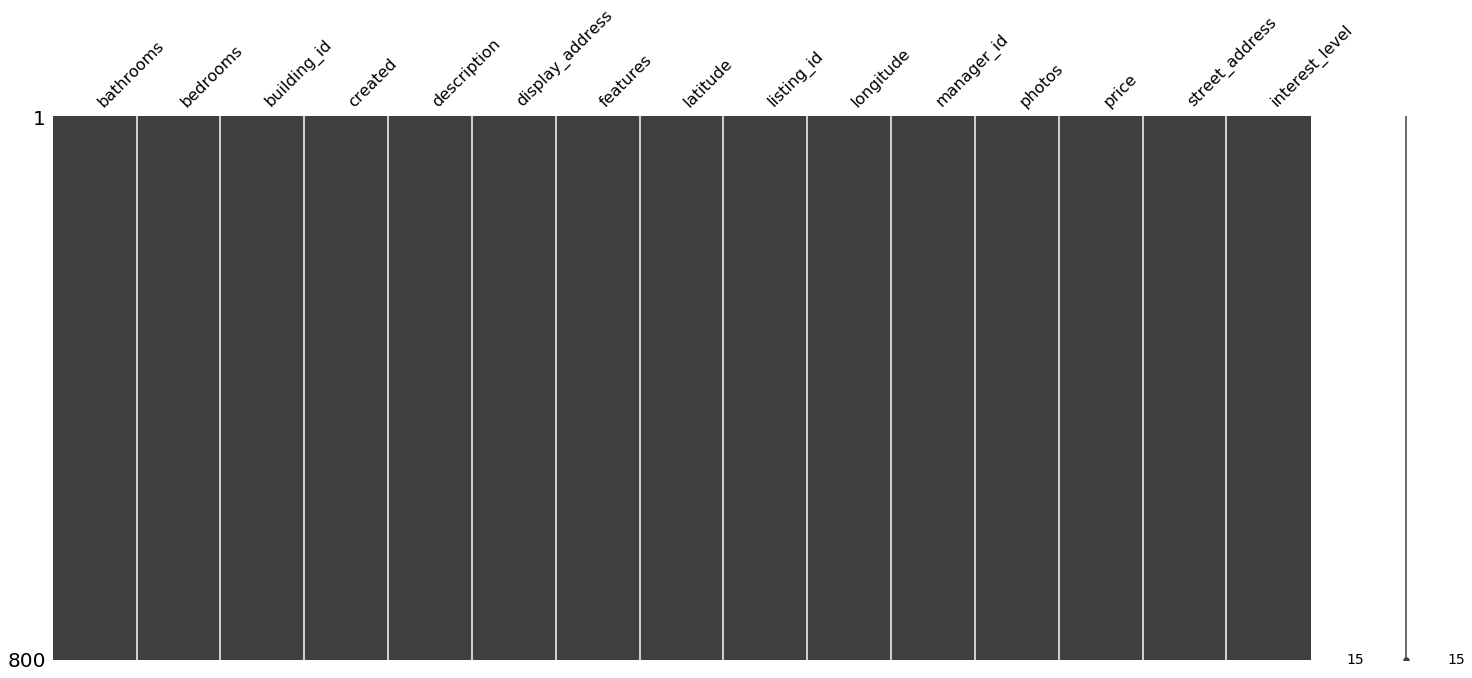

In [18]:
msno.matrix(df)

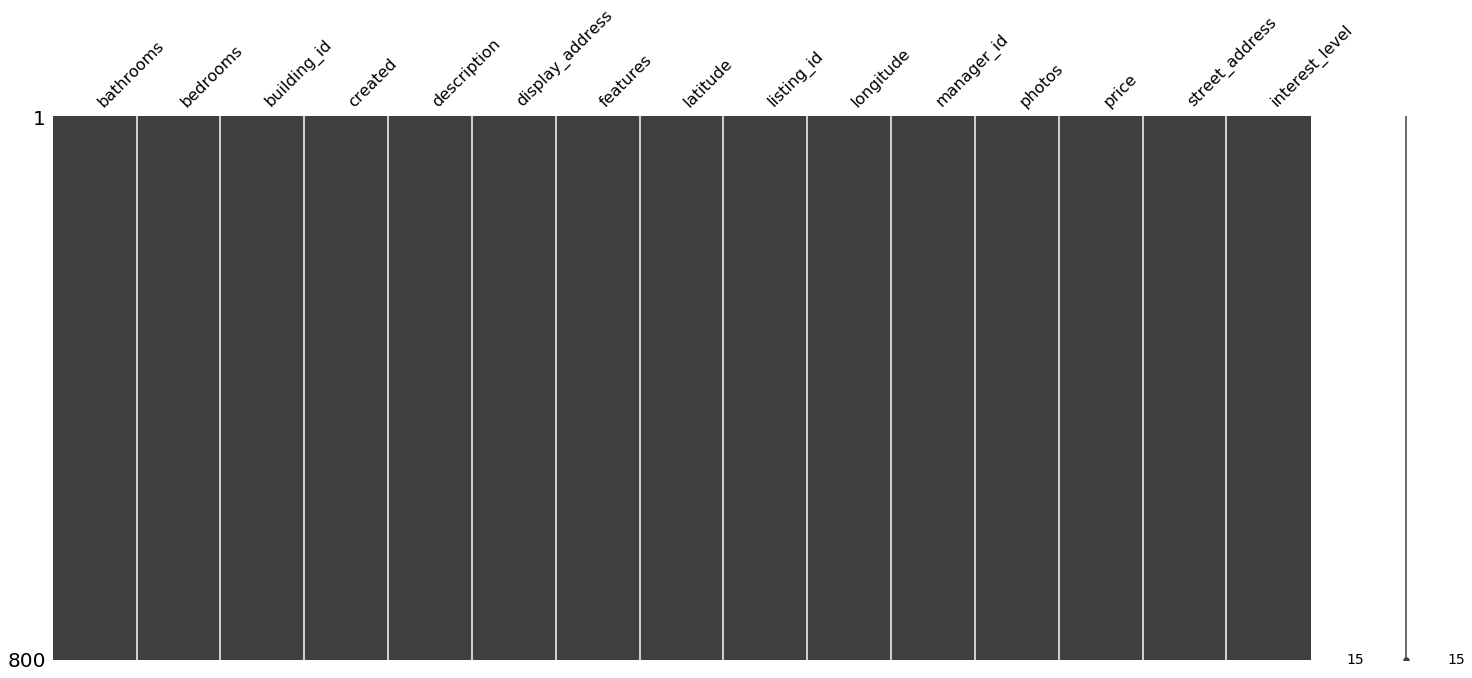

In [19]:
df = df.dropna(how='any')
msno.matrix(df)

## Fitting base model & learning parameters

In [20]:
x = np.array(df[var])
#y = np.array(df.iloc[:,81])
y = np.array(df['interest_level'])

In [21]:
#Inputs to active learning & random learning function
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42)

print(x_test.shape)
print(len(np.unique(y_test)))

(160, 5)
3


In [22]:
x_tagged, x_untagged, y_tagged, y_untagged = train_test_split(x_train,y_train,test_size=0.10,random_state=42)
acc_act = []
acc_rand = []
n = 200

print(x_untagged.shape)
print(len(np.unique(y_untagged)))

(64, 5)
3


In [ ]:
#Base model pipeline
svm = SVC(kernel='poly')
svm_pipe = make_pipeline(svm)
svm_pipe.fit(x_tagged,y_tagged)

param_grid = {'svc__C':np.logspace(-3,2,5),'svc__degree':[2,3]}

## Creating Random & Active learning f(x) for comparison

In [ ]:
def active_learning(svm_pipe,x_tagged,x_untagged,y_tagged,y_untagged,x_test,y_test,acc_act,n):
    for i in range(0,n): 
        #Grid Model runs on train data stack
        svm_pipe.fit(x_tagged,y_tagged)
        y_pred = svm_pipe.predict(x_test)
        
        #Model validated against test data stack & appended to the acc list
        acc_act.append(accuracy_score(y_pred,y_test))
        
        #Detect which sample needs to be labelled (uncertainity based on distance from hyperplane)
        act_ix = np.argmin([max(i) for i in np.abs(svm_pipe.decision_function(x_untagged))])
        
        #Take that vector and label it (irl: manually, here: from existing data)
        act_vector = x_untagged[act_ix].reshape(1,x_untagged.shape[1])
        act_label = y_untagged[act_ix]
        
        #Update training data
        x_tagged = np.r_[x_tagged,act_vector]
        y_tagged = np.append(y_tagged,act_label)
        
        #Update testing data
        x_untagged = np.delete(x_untagged,act_ix,0)
        y_untagged = np.delete(y_untagged,act_ix)
        
        print("iteration completed -> ",i,"... size of train ->",x_train.shape,"... size of test ->",x_test.shape)
        #Repeat n number of times
    return acc_act

In [ ]:
def random_learning(svm_pipe,x_tagged,x_untagged,y_tagged,y_untagged,x_test,y_test,acc_rand,n):
    for i in range(0,n): 
        #Grid Model runs on train data stack
        svm_pipe.fit(x_tagged,y_tagged)
        y_pred = svm_pipe.predict(x_test)
        
        #Model validated against test data stack & appended to the acc list
        acc_rand.append(accuracy_score(y_pred,y_test))
        
        #Detect which sample needs to be labelled (uncertainity based on distance from hyperplane)
        act_ix = random.randint(0,len(x_test)-1)
        
        #Take that vector and label it (irl: manually, here: from existing data)
        act_vector = x_untagged[act_ix].reshape(1,x_untagged.shape[1])
        act_label = y_untagged[act_ix]
        
        #Update training data
        x_tagged = np.r_[x_tagged,act_vector]
        y_tagged = np.append(y_tagged,act_label)
        
        #Update testing data
        x_untagged = np.delete(x_untagged,act_ix,0)
        y_untagged = np.delete(y_untagged,act_ix)
        
        #print("iteration completed -> ",i,"... size of train ->",x_train.shape,"... size of test ->",x_test.shape)
        #Repeat n number of times
    return acc_rand

## Calling learners for score plots

In [ ]:
#Calling active learning function and random learning function
plt.plot(active_learning(svm_pipe,x_tagged,x_untagged,y_tagged,y_untagged,x_test,y_test,acc_act,n),color='blue')
#plt.plot(random_learning(svm_pipe,x_tagged,x_untagged,y_tagged,y_untagged,x_test,y_test,acc_rand,n),color='red')

## Observations and conclusions

1. The blue line represents the active learner which gets user inputs based on "uncertainity", while red line represents the case when user is being asked to label samples randomly.
2. The model clearly shows that the rate of semi-supervised learning for the active learner is much higher than the random learner for the first 55 iterations. This means that the active learner will learn faster with lesser number of inputs, unlike the random learner.
3. However, post the 55th user input (iteration), it seems that there was no need for the active learner to query the user since random data labels are enough to learn how to classify the 8 mice.
4. Around the 100-175 mark is where the con of this method comes in. Very clearly, the whole strategy is based on prioritizing what to get labeled based on a specific strategy (uncertainity in this case). This means that there is some knowledge being withheld from the model for the first few iterations. This is where random learner wins.
5. In simple terms, the active learner learns fast with minimum effort, but random learner is slow and steady. Ultimately both will reach the same state given enough data.

## References for more reading

- https://www.youtube.com/watch?v=8Jwp4_WbRio
- https://en.wikipedia.org/wiki/Active_learning_(machine_learning)
- https://stackoverflow.com/questions/37012320/active-learning-e-g-pool-sampling-for-svm-in-python?rq=1
- http://inspirehep.net/record/1667231/plots
- https://prodi.gy/
- http://hunch.net/~active_learning/active_learning_icml09.pdf

<i>- Akshay Sehgal (www.akshaysehgal.com)</i>